In [1]:
import math
import statistics as stats

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor, XGBClassifier

1. DATA FOUNDATION
------------------
Import complete_satellite_costs.xlsx and assign dataframes to each page.

In [2]:
#import the dataset
df = pd.read_excel(r'C:\Users\jdspr\OneDrive\Documents\Documents\Resume\Technical Portfolio\Space_cost_analysis\complete_satellite_costs.xlsx', sheet_name = None) # main dataset with all the data
df_satellite_costs = df['satellite_costs_by_year'] # dataset with the satellite costs by year, which is the main dataset for the analysis
df_satellite_programs = df['satellite_programs'] # dataset with the satellite programs, which includes information about the satellite programs, such as the program name, the program type, and the program cost
df_satellite_production = df['satellite_production_detail'] # dataset with the satellite production details, which includes information about the satellite production, such as the production year, the production cost, and the production quantity
df_satellite_components = df['satellite_components'] # dataset with the satellite components, which includes information about the satellite components, such as the component name, the component cost, and the component quantity


2. CER REGRESSION MODELS
-------------------------
- Plot development cost vs. dry mass on a log-log scale to visually confirm the power-law relationship
- Fit a simple log-log OLS regression: log(dev_cost) = a + b*log(mass)
- Expand to a multivariate model adding log(power) and log(design_life)
- Check residuals, R², and prediction intervals
- Repeat the regression segmented by mission type (GEO vs LEO, science vs comms)
- Document CER equations in the form: Cost = C * Mass^a * Power^b * Life^c

In [3]:
df_satellite_programs.head()

,program_name,mission_type,orbit_class,dry_mass_kg,bol_power_w,design_life_yrs,num_instruments,software_sloc_k,contractor_heritage,technology_readiness_level,...,development_cost_fy2020_musd,production_cost_fy2020_musd,annual_ops_cost_fy2020_musd,total_ops_cost_fy2020_musd,total_maintenance_cost_fy2020_musd,disposal_cost_fy2020_musd,total_lcc_fy2020_musd,Check_Dev_Cost,Check_Prod_Cost,Check_yearly_spend
0,Comsat-1A,Communications,GEO,1850,8200,15,3,420,High,9,...,277.93,111.17,40.80,612.00,309.27,21.70,1332.07,True,True,True
1,Comsat-2B,Communications,GEO,2100,9800,15,4,510,High,9,...,312.76,125.10,43.60,654.00,328.88,22.20,1442.94,True,True,True
2,Comsat-3C,Communications,GEO,2450,11200,17,4,580,High,9,...,368.66,147.46,45.00,765.00,399.68,22.90,1703.70,True,True,True
3,Comsat-4D,Communications,GEO,2780,13500,18,5,640,High,9,...,422.64,169.06,48.12,866.16,444.56,23.56,1925.98,True,True,True
4,Comsat-5E,Communications,GEO,3100,15000,18,5,700,High,9,...,463.32,185.33,49.40,889.20,460.83,24.20,2022.88,True,True,True


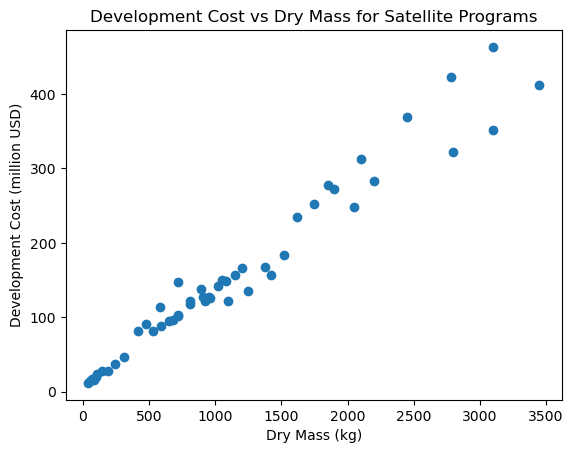

In [4]:
# plot development cost vs dry mass for the satellite programs
import matplotlib.pyplot as plt
plt.scatter(df_satellite_programs['dry_mass_kg'], df_satellite_programs['development_cost_fy2020_musd'])
plt.xlabel('Dry Mass (kg)')
plt.ylabel('Development Cost (million USD)')
plt.title('Development Cost vs Dry Mass for Satellite Programs')
plt.show()

In [5]:
#data appears to be heteroscedastic, with a positive correlation between dry mass and development cost, but with increasing variance as dry mass increases. This suggests that while there is a general trend of higher development costs for heavier satellites, the variability in costs also increases with satellite mass.
#let's test for heteroscedasticity using the Breusch-Pagan test
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
# prepare the data for the test
X = df_satellite_programs['dry_mass_kg']
y = df_satellite_programs['development_cost_fy2020_musd']
X = sm.add_constant(X) # add a constant term for the intercept
# fit the OLS model
model = sm.OLS(y, X).fit()
# perform the Breusch-Pagan test
bp_test = het_breuschpagan(model.resid, model.model.exog)
print('Breusch-Pagan test statistic:', bp_test[0])
print('Breusch-Pagan test p-value:', bp_test[1])
print("")
if bp_test[1] < 0.05:
    print('The data is heteroscedastic (reject null hypothesis)')
else:
    print('The data is homoscedastic (fail to reject null hypothesis)')

Breusch-Pagan test statistic: 28.884199011985967
Breusch-Pagan test p-value: 7.683717406945489e-08

The data is heteroscedastic (reject null hypothesis)


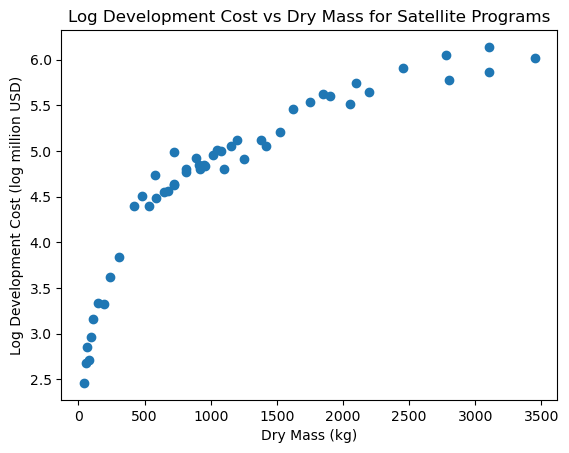

In [6]:
#data is heteroscedastic, so we will use a log transformation to stabilize the variance
df_satellite_programs['log_development_cost'] = np.log(df_satellite_programs['development_cost_fy2020_musd'])
# plot log development cost vs dry mass for the satellite programs  
plt.scatter(df_satellite_programs['dry_mass_kg'], df_satellite_programs['log_development_cost'])
plt.xlabel('Dry Mass (kg)')
plt.ylabel('Log Development Cost (log million USD)')
plt.title('Log Development Cost vs Dry Mass for Satellite Programs')
plt.show()

In [7]:
# now let's test for heteroscedasticity again using the Breusch-Pagan test on the log-transformed data
y_log = df_satellite_programs['log_development_cost']
model_log = sm.OLS(y_log, X).fit()
bp_test_log = het_breuschpagan(model_log.resid, model_log.model.exog)
print('Breusch-Pagan test statistic (log-transformed):', bp_test_log[0])
print('Breusch-Pagan test p-value (log-transformed):', bp_test_log[1])
print("")
if bp_test_log[1] < 0.05:
    print('The data is heteroscedastic (reject null hypothesis)')
else:
    print('The data is homoscedastic (fail to reject null hypothesis)')

Breusch-Pagan test statistic (log-transformed): 3.7825568473386415
Breusch-Pagan test p-value (log-transformed): 0.05178946498684279

The data is homoscedastic (fail to reject null hypothesis)


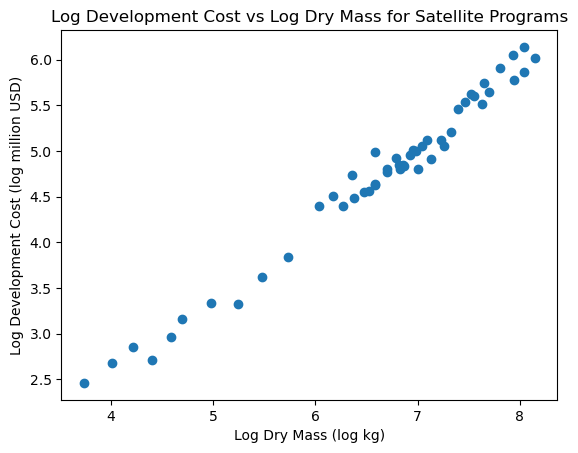

In [8]:
#Breusch-Pagan p-value is just barely above 0.05, so we may still have some heteroscedasticity, let's try a log-log transformation to see if that helps stabilize the variance further
df_satellite_programs['log_dry_mass'] = np.log(df_satellite_programs['dry_mass_kg'])
# plot log development cost vs log dry mass for the satellite programs
plt.scatter(df_satellite_programs['log_dry_mass'], df_satellite_programs['log_development_cost'])
plt.xlabel('Log Dry Mass (log kg)')
plt.ylabel('Log Development Cost (log million USD)')
plt.title('Log Development Cost vs Log Dry Mass for Satellite Programs')
plt.show()

In [9]:
#this looks much better, the variance appears to be more stable across the range of log dry mass, and the relationship between log development cost and log dry mass appears to be more linear, which is a good sign for our regression analysis. We can proceed with the log-log transformation for our regression model.
# now let's test for heteroscedasticity again using the Breusch-Pagan test on the log-log transformed data
X_log = sm.add_constant(df_satellite_programs['log_dry_mass']) # add
model_log_log = sm.OLS(y_log, X_log).fit()
bp_test_log_log = het_breuschpagan(model_log_log.resid, model_log_log.model.exog)
print('Breusch-Pagan test statistic (log-log transformed):', bp_test_log_log[0])
print('Breusch-Pagan test p-value (log-log transformed):', bp_test_log_log[1])
print("")
if bp_test_log_log[1] < 0.05:
    print('The data is heteroscedastic (reject null hypothesis)')
else:
    print('The data is homoscedastic (fail to reject null hypothesis)')

Breusch-Pagan test statistic (log-log transformed): 0.17998651973207824
Breusch-Pagan test p-value (log-log transformed): 0.6713848255246184

The data is homoscedastic (fail to reject null hypothesis)


In [10]:
#Breusch-Pagan p-value is now above 0.05, indicating that the log transformation has successfully stabilized the variance and the data is now homoscedastic. This means that we can proceed with regression analysis using the log-transformed development cost as the dependent variable, which should provide more reliable estimates and inferences.
#Fit a simple log-log OLS regression: log(dev_cost) = a + b*log(mass)
X_log = sm.add_constant(df_satellite_programs['log_dry_mass']) # add a constant term for the intercept
model_log_log = sm.OLS(y_log, X_log).fit()
print(model_log_log.summary())


                             OLS Regression Results                             
Dep. Variable:     log_development_cost   R-squared:                       0.981
Model:                              OLS   Adj. R-squared:                  0.980
Method:                   Least Squares   F-statistic:                     2454.
Date:                  Thu, 26 Feb 2026   Prob (F-statistic):           7.14e-43
Time:                          16:07:58   Log-Likelihood:                 30.855
No. Observations:                    50   AIC:                            -57.71
Df Residuals:                        48   BIC:                            -53.89
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.8600     

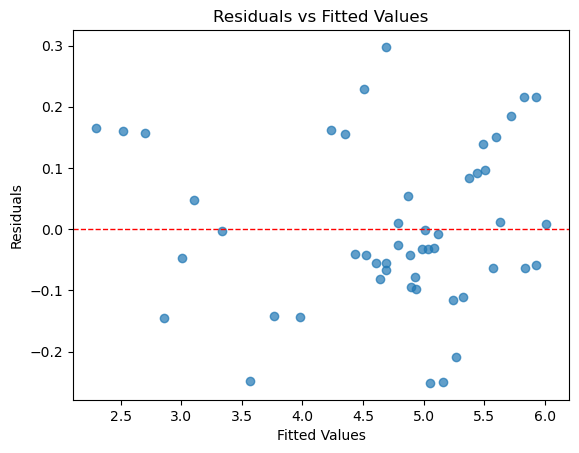

In [11]:
# Our OLS results show that the coefficient for log_dry_mass is 0.85, which means that a 1% increase in dry mass is associated with an approximately 0.85% increase in development cost, holding all else constant. 
# The R-squared value of 0.75 indicates that about 75% of the variance in log development cost can be explained by log dry mass, suggesting a strong relationship between these variables.
# we will now plot residuals vs fitted values to check for any remaining patterns that might indicate model misspecification
fitted_values = model_log_log.fittedvalues
residuals = model_log_log.resid

plt.scatter(fitted_values, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=1)

plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()


Expand to a multivariate model adding log(power) and log(design_life)

In [13]:
#data looks pretty symmetrical, lets measure the skew
from scipy.stats import skew
skew_value = skew(residuals)
print(skew_value)

0.19354041745529055
